
## Dataset Description

Our analysis is based on the **Spotify Million Playlist Dataset (MPD)**, introduced as part of the RecSys Challenge 2018 by Spotify Research [1]. The dataset contains **1,000,000 user-generated playlists**, sampled from over 4 billion public playlists created on the Spotify platform between January 2010 and November 2017. Each playlist includes metadata such as playlist title, number of tracks, number of albums, and duration, as well as detailed track-level information including track name, artist name, album name, and track duration. In total, the MPD comprises **over 2 million unique tracks by nearly 300,000 artists**. Playlists were sampled with randomization and manually filtered to ensure quality and remove offensive content [2].

In our report we have decided to use the first 1000 playlists as the foundation for our network. 

To enrich the network with semantic information, we scraped lyrics for the tracks associated with each artist from the Genius website[3] using a Genius API[4]. For each artist, we collected the full text of their songs, including verses, choruses, and bridges, and stored them in plain text files. These files were aggregated at the artist level, resulting in a single combined lyric corpus per artist.

**References**  
[1] Spotify Research. *The Million Playlist Dataset Challenge*. RecSys Challenge 2018. Available at: https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset
[2] McFee, B., et al. (2018). *The Million Playlist Dataset Challenge*. Proceedings of the ACM RecSys Challenge 2018.  
[3] https://genius.com/  
[4] https://lyricsgenius.readthedocs.io/en/master/reference/genius.html  

## Loading the playlist data into dictionaries

In [7]:
import networkx as nx
from collections import defaultdict
from itertools import combinations
from pathlib import Path
import lyricsgenius
import os
import re
import time
import json
import pandas as pd
import backboning as bb  # assuming backboning.py is in your PYTHONPATH
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
# number of playlist to process out of the slice files
NUM_PLAYLISTS = 1000

# Path to your original slice file
folder_path = Path(r"/Users/noa/Desktop/02805 - Social Graphs/playlist_data/")

# folder with artist/lyrics files
artist_folder = Path(r"/Users/noa/Desktop/02805 - Social Graphs/artist_lyrics_cleaned")

# Load all mpd slice JSON files in the folder and merge their playlists
file_list = sorted(folder_path.glob("mpd.slice.*.json"))
playlists = []
for fp in file_list:
    with open(fp, 'r', encoding='utf-8') as f:
        data = json.load(f)
        playlists.extend(data.get("playlists", []))

print(f"Loaded {len(file_list)} files, total playlists merged: {len(playlists[:])}")

Loaded 0 files, total playlists merged: 0


We have decided to filter out some of the playlists using the following criteria:
- A playlist should contain between 20 and 100 songs
  - This is done such that we don't have playlists without themes, as we expect playlists of length > 100 to be more randomly sampled and less curated.
  - Playlists of less than 20 songs might not have enough songs for it to have thematic meaning.
- Each playlist should contain at least 6 different artists. 
  - this is done to ensure variety in the playlists.

In [4]:
# Accumulators
artist_songs = defaultdict(set)
artist_playlists = defaultdict(set)
artist_albums = defaultdict(set)
artist_durations = defaultdict(list)
edge_playlists = defaultdict(set)

def normalize_artist_name(name):
    if not name:
        return None
    return name.replace(' ', '_').strip()

included_playlists = 0

for pl in playlists[:NUM_PLAYLISTS]:
    pid = pl.get("pid")
    tracks = pl.get("tracks", [])
    # filter playlists by track count and unique artist count
    if not (20 <= len(tracks) <= 100):
        continue

    # build normalized set of unique artists for this playlist
    unique_artists = {normalize_artist_name(t["artist_name"]) for t in tracks if t.get("artist_name")}
    unique_artists = {a for a in unique_artists if a}  # drop Nones/empty
    if len(unique_artists) < 6:
        continue

    included_playlists += 1

    # collect songs, albums, durations, playlist membership per artist
    for t in tracks:
        raw_artist = t.get("artist_name")
        artist = normalize_artist_name(raw_artist)
        if not artist:
            continue
        track_name = t.get("track_name")
        album_name = t.get("album_name")
        duration = t.get("duration_ms")

        if track_name:
            artist_songs[artist].add(track_name)
        if album_name:
            artist_albums[artist].add(album_name)
        if duration:
            artist_durations[artist].append(duration)
        artist_playlists[artist].add(pid)

    # increment edge counters for every pair of (normalized) artists in this playlist
    for a, b in combinations(sorted(unique_artists), 2):
        edge_playlists[(a, b)].add(pid)

print(f"Included playlists: {included_playlists}")


Included playlists: 583


The assumptions have filtered out approximately half of the playlists. It is important to remark that the lyrics that is added to all artists as an attribute, is the scraping from all 1000 playlists text from Genius.

## Scrape the lyrics

OBS! This code was run on the HPC and all concatenated lyrics were saved in txt files.

We have had these considerations
- Avoid duplicates: Only fetch lyrics for unique songs per artist.
- Rate limits: Genius API has limits, so we have needed to add delays.

In [ ]:
import json
from pathlib import Path
import lyricsgenius
import os
import re
import time
from collections import defaultdict

# Folder to save lyrics
lyrics_folder = Path("artist_lyrics")
lyrics_folder.mkdir(exist_ok=True)

# Setup Genius API
GENIUS_ACCESS_TOKEN = "IKoqZN1ANyU_2G6zmTPF2xlaH2OlIEEUlDoD97Mo9-P_A6-2QgnSoQlwsJ3Hy3DY"  # <--- paste your token

# Initialize Genius client
genius = lyricsgenius.Genius(
    GENIUS_ACCESS_TOKEN,
    remove_section_headers=True,   # cleans up [Verse], etc.
    timeout=15,
    retries=3
)

artist_lyrics = defaultdict(str)

for artist, songs in artist_songs.items():
    for track_name in songs:
        try:
            song = genius.search_song(track_name, artist)
            if song and song.lyrics:
                artist_lyrics[artist] += "\n" + song.lyrics
        except Exception as e:
            print(f"Error retrieving {track_name} by {artist}: {e}")
        time.sleep(1)  # Avoid hitting rate limits

# Save lyrics to files
for artist, lyrics in artist_lyrics.items():
    safe_name = re.sub(r'[^\w\s-]', '', artist).strip().replace(' ', '_')
    file_path = lyrics_folder / f"{safe_name}.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(lyrics)

## Clean and load lyrics for all artists

In [ ]:
import re
from pathlib import Path
from typing import Iterable, Union
import argparse

def remove_metadata_blocks_from_text(text: str) -> str:
    """
    Remove metadata blocks from a text.
    Returns the cleaned text.
    """
    lines = text.splitlines(keepends=True)
    out_lines = []
    i = 0

    # match any line that starts with optional spaces, then digits, then 'Contributors'
    pattern = re.compile(r'^\s*\d+\s+Contributors')  # matches start of metadata block

    #match any contiguous non-space "word" that ends with 'Embed'
    embed_pat = re.compile(r'\b\S+Embed\b', re.IGNORECASE)

    while i < len(lines):
        # remove tokens like '87Embed' but NOT standalone 'Embed'
        line = embed_pat.sub('', lines[i])

        if pattern.match(line):
            # skip this metadata line and subsequent non-blank lines
            i += 1
            while i < len(lines) and lines[i].strip() != "":
                i += 1
            # if there's a blank line, preserve it (to keep stanza breaks)
            if i < len(lines) and lines[i].strip() == "":
                out_lines.append(lines[i])
                i += 1
        else:
            out_lines.append(line)
            i += 1

    return "".join(out_lines)


def process_file(path: Union[str, Path], inplace: bool = True, backup: bool = True, encoding: str = "utf-8") -> str:
    """
    Process a single file. If inplace is True, overwrite the file (optionally making a .bak backup).
    Returns the cleaned text.
    """
    p = Path(path)
    text = p.read_text(encoding=encoding)
    cleaned = remove_metadata_blocks_from_text(text)

    if inplace:
        if backup:
            bak = p.with_suffix(p.suffix + ".bak")
            bak.write_text(text, encoding=encoding)
        p.write_text(cleaned, encoding=encoding)

    return cleaned


def process_paths(paths: Iterable[Union[str, Path]], **kwargs) -> None:
    """
    Process multiple files or directories. If a directory is supplied, all files
    inside (non-recursive) will be processed. kwargs are passed to process_file.
    """
    for p in paths:
        p = Path(p)
        if p.is_dir():
            for child in p.iterdir():
                if child.is_file():
                    process_file(child, **kwargs)
        elif p.is_file():
            process_file(p, **kwargs)

In [ ]:
# Clean all files in a folder
PATH = '/Users/noa/Desktop/02805 - Social Graphs/artist_lyrics_cleaned' # TODO
process_paths([PATH], inplace=True, backup=False, encoding="utf-8")

Now we create the dictionary of the lyrics for each artist

In [5]:
lyrics_dict = {}

# Load lyrics for artists
for txt_file in artist_folder.glob("*.txt"):
    artist_name = txt_file.stem  # filename without extension
    with open(txt_file, 'r', encoding='utf-8') as f:
        lyrics_dict[artist_name.lower()] = f.read()

## Creating the undirected co-occurence graph
From the MPD, we construct an **artist co-occurrence network** where nodes represent artists and edges represent co-occurrence in playlists. An edge between two artists indicates that they appear together in at least one playlist. 

**Nodes** represent artists.
Node attributes:
- songs: set of track names
- playlists: set of playlist IDs
- num_playlists: count of playlists
- num_songs: count of songs
- avg_song_duration: average track duration
- albums: set of album names
- lyrics: if available (for artists like 2Pac)

**Edges** represent co-occurrence in playlists.
Edge attributes:
- shared_playlists: set of playlist IDs
- weight: number of shared playlists
- co_occurrence_count: number of times they appear together

We are not keeping nodes where:
- the Genius API was not able to find the lyrics of the artist
- Artist that have less than four songs represented in the 1000 playlists

Lastly we only keep the largest connected component as the main graph.

In [6]:
# Build the graph
G = nx.Graph()

# Add nodes with attributes
for artist in artist_songs.keys():
    num_playlists = len(artist_playlists[artist])
    num_songs = len(artist_songs[artist])
    avg_duration = sum(artist_durations[artist]) / len(artist_durations[artist]) if artist_durations[artist] else None
    lyrics = lyrics_dict.get(artist.lower(), None)

    G.add_node(artist,
               songs=list(artist_songs[artist]),
               albums=list(artist_albums[artist]),
               playlists=list(artist_playlists[artist]),
               num_playlists=num_playlists,
               num_songs=num_songs,
               avg_song_duration=avg_duration,
               lyrics=lyrics)

# Add edges with attributes
for (a, b), pls in edge_playlists.items():
    G.add_edge(a, b,
               shared_playlists=list(pls),
               weight=len(pls),
               co_occurrence_count=len(pls))

# remove nodes where lyrics attribute is missing or empty
nodes_to_remove = [n for n, attrs in G.nodes(data=True) if not attrs.get('lyrics')]

# remove nodes from the graph where num_songs is less than 4 
nodes_to_remove += [n for n, attrs in G.nodes(data=True) if attrs.get('num_songs', 0) < 4]

G.remove_nodes_from(nodes_to_remove) 

# keep largest connected component only
if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()

print(f"After removing artists with no lyrics: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

After removing artists with no lyrics: 1015 nodes, 63840 edges


## Backbone

Because our network is very dense, we are going to filter out some nodes and edges finding the backbone of the graph. we have chosen to make a Noise-Corrected backbone (NC), as it is well-suited for weighted networks where node activity varies greatly, such as the co-occurrence network of artists. This backbone was introduced by Coscia and Neffke (2017) and their backboning.py file is used to produce the backbone [1].

The goal is to look at strong connections of artists, i.e. connections where artists are appearing on a significant amount of playlists together. 
In the original graph, hubs (popular artists) accumulate many edges simply because they appear on numerous playlists. For example, the node "Rihanna" is connected to almost half of the other nodes in the original graph. These connections may not all represent meaningful associations. The NC backbone addresses this by comparing each edge weight, $n_{ij}$, to an expected value under a null model that accounts for both nodes’ ($i$'s and $j$'s) overall activity. Edges that are stronger than expected are kept, while those likely due to random co-occurrence are removed.

[1] https://www.michelecoscia.com/?page_id=287.  
[2]

The function below uses the package, to create the backbone. The second plots number of edges vs. threshold from the backbone. 

In [32]:
def nc_backbone_from_nx(G, weight_attr="weight", threshold=2.0, calculate_p_value=False):
    """
    Compute Noise-Corrected backbone from an undirected NetworkX graph.

    Args:
        G (nx.Graph): Undirected weighted graph.
        weight_attr (str): Edge attribute name for weights.
        threshold (float): Threshold for backbone extraction.
        calculate_p_value (bool): If True, compute p-values instead of NC score.

    Returns:
        backbone_edges (pd.DataFrame): DataFrame with columns [src, trg, nij, score].
    """
    # 1. Convert NetworkX graph to DataFrame
    edges = []
    for u, v, data in G.edges(data=True):
        w = data.get(weight_attr, 1.0)  # default weight = 1 if missing
        edges.append({"src": u, "trg": v, "weight": w})
    df = pd.DataFrame(edges)

    # 2. Compute NC backbone
    nc_table = bb.noise_corrected(
        df.rename(columns={"weight": "nij"}),  # rename for compatibility
        undirected=True,
        return_self_loops=False,
        calculate_p_value=calculate_p_value
    )

    # 3. Apply thresholding
    backbone = bb.thresholding(nc_table, threshold)

    return backbone


def plot_nc_backbone_thresholds(G, weight_attr="weight", thresholds=None):
    if thresholds is None:
        thresholds = [0.5, 1, 1.5, 2, 2.5, 3]

    # Convert NetworkX graph to DataFrame
    edges = [{"src": u, "trg": v, "nij": data.get(weight_attr, 1.0)}
             for u, v, data in G.edges(data=True)]
    df = pd.DataFrame(edges)

    # Compute NC scores
    nc_table = bb.noise_corrected(df, undirected=True, return_self_loops=False)

    # Calculate edge counts for each threshold
    edge_counts = []
    for t in thresholds:
        backbone = bb.thresholding(nc_table, t)
        edge_counts.append(len(backbone))

    # Plot using Plotly
    fig = px.line(x=thresholds, y=edge_counts, markers=True,
                  labels={'x': 'Threshold', 'y': 'Number of Edges'},
                  title='NC Backbone Edge Count vs Threshold')
    fig.show()

    return thresholds, edge_counts


Firstly we look at the number of edges vs the threshold for the backone construction.  

In [33]:
# import original graph
path = Path(r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Project/MUSIC/artist_network.graphml")

G_lyrics = nx.read_graphml(path)

# number of nodes and edges in original graph
print(f"Original graph has {G_lyrics.number_of_nodes()} nodes and {G_lyrics.number_of_edges()} edges.")

plot_nc_backbone_thresholds(G_lyrics, weight_attr="weight")

Original graph has 1015 nodes and 63840 edges.


Calculating NC score...


([0.5, 1, 1.5, 2, 2.5, 3], [26121, 23511, 21245, 19368, 17743, 16333])

Below the backbone is generated with a threshold of 3. This is a really strict threshold, but as the original graph is very dense and noisy, we have chosen to filter as much as possible. We se above that low thresholds will produce backbones that extremely dense, with number of edges being between 26000 and 18000 more or less.

Calculating NC score...


Backbone graph has 1004 nodes and 16333 edges.


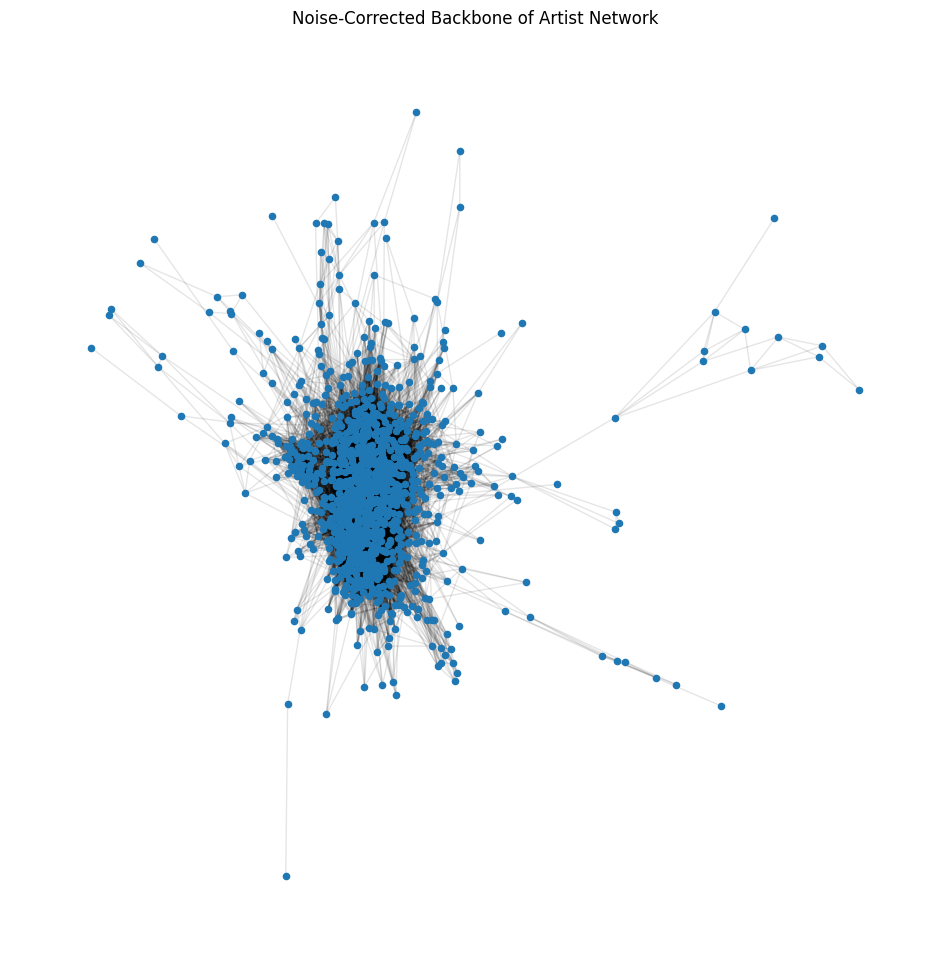

In [34]:

# Backbone extraction
NC_backbone_pd = nc_backbone_from_nx(G_lyrics, weight_attr="weight", threshold=3.0, calculate_p_value=False)
NC_backbone = nx.from_pandas_edgelist(NC_backbone_pd, source='src', target='trg', edge_attr='nij')

# add attributes on nodes and edges from original graph to backbone
for u, v, data in NC_backbone.edges(data=True):
    if G_lyrics.has_edge(u, v):
        for attr, value in G_lyrics[u][v].items():
            NC_backbone[u][v][attr] = value

for n, data in NC_backbone.nodes(data=True):
    if n in G_lyrics.nodes:
        for attr, value in G_lyrics.nodes[n].items():
            NC_backbone.nodes[n][attr] = value

# number of nodes and edges in backbone
print(f"Backbone graph has {NC_backbone.number_of_nodes()} nodes and {NC_backbone.number_of_edges()} edges.")

# save backbone to file
nx.write_graphml(NC_backbone, "/Users/iben/Desktop/Social_graphs/SocialGraphs/Project/MUSIC/artist_network_NCbackbone_3.graphml")

# plot backbone
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(NC_backbone, k=0.1)  # positions for all nodes
nx.draw_networkx_nodes(NC_backbone, pos, node_size=20)
nx.draw_networkx_edges(NC_backbone, pos, alpha=0.1)
plt.title("Noise-Corrected Backbone of Artist Network")
plt.axis('off')
plt.show()

The backbone has 1004 nodes and 16333 edges. 
We look at the top 10 artist by degree and top 10 edges by weight, to see if anything major changed. 

In [35]:
# top 10 artists by degree in NC backbone
print("Top 10 artists by degree in NC backbone:")
degree_dict = dict(NC_backbone.degree())
top_10_artists = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_artists, "\n")

print("Top 10 weighted edges in NC backbone:")
# top 10 weighted edges in NC backbone
weighted_edges = nx.get_edge_attributes(NC_backbone, 'nij')
top_10_weighted_edges = sorted(weighted_edges.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_weighted_edges, "\n")

print("Top 10 artists by degree in original graph:")
# top 10 artisits by degree in original graph
degree_dict_original = dict(G_lyrics.degree())
top_10_artists_original = sorted(degree_dict_original.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_artists_original, "\n")

print("Top 10 weighted edges in original graph:")
# top 10 weighted edges in original graph
weighted_edges_original = nx.get_edge_attributes(G_lyrics, 'weight')
top_10_weighted_edges_original = sorted(weighted_edges_original.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_weighted_edges_original, "\n")

print("Degree comparison for top artists:")
# degree of top 10 artists from original graph in original graph vs NC backbone
for artist, _ in top_10_artists_original:
    degree_original = degree_dict_original.get(artist, 0)
    degree_backbone = degree_dict.get(artist, 0)
    print(f"Artist: {artist}, Degree in Original: {degree_original}, Degree in NC Backbone: {degree_backbone}")
# degree of top 10 artists from NC backbone in original graph vs NC backbone
for artist, _ in top_10_artists:
    degree_original = degree_dict_original.get(artist, 0)
    degree_backbone = degree_dict.get(artist, 0)
    print(f"Artist: {artist}, Degree in Original: {degree_original}, Degree in NC Backbone: {degree_backbone}")

Top 10 artists by degree in NC backbone:
[('Yeah_Yeah_Yeahs', 92), ('David_Bowie', 83), ('Billy_Joel', 81), ('Lana_Del_Rey', 80), ('A_R_I_Z_O_N_A', 79), ('Aerosmith', 79), ('Coldplay', 78), ('The_Shins', 78), ('The_xx', 77), ('Eagles', 77)] 

Top 10 weighted edges in NC backbone:
[(('Drake', 'The_Weeknd'), 47), (('Drake', 'Kanye_West'), 45), (('Rihanna', 'The_Weeknd'), 35), (('Drake', 'Kendrick_Lamar'), 34), (('Drake', 'Future'), 31), (('Rae_Sremmurd', 'Big_Sean'), 30), (('Drake', 'Rae_Sremmurd'), 29), (('Rihanna', 'Chris_Brown'), 28), (('Chris_Brown', 'Drake'), 28), (('Major_Lazer', 'The_Chainsmokers'), 28)] 

Top 10 artists by degree in original graph:
[('Rihanna', 587), ('The_Weeknd', 537), ('Ed_Sheeran', 531), ('Drake', 531), ('Coldplay', 511), ('Maroon_5', 502), ('Kanye_West', 493), ('Imagine_Dragons', 482), ('Calvin_Harris', 468), ('Ariana_Grande', 449)] 

Top 10 weighted edges in original graph:
[(('Drake', 'The_Weeknd'), 47), (('Drake', 'Kanye_West'), 45), (('Rihanna', 'Drake')

As we expected, many of the edges of the popular bands has been removed. The edges of highest weight has been preserved, as they are all highly significant. Important to note, the top artists by degree have change. This means that the top artists in the original graph have many unsignificant edges.

Below we plot the degree dist. of the original graph and the NC backbone.

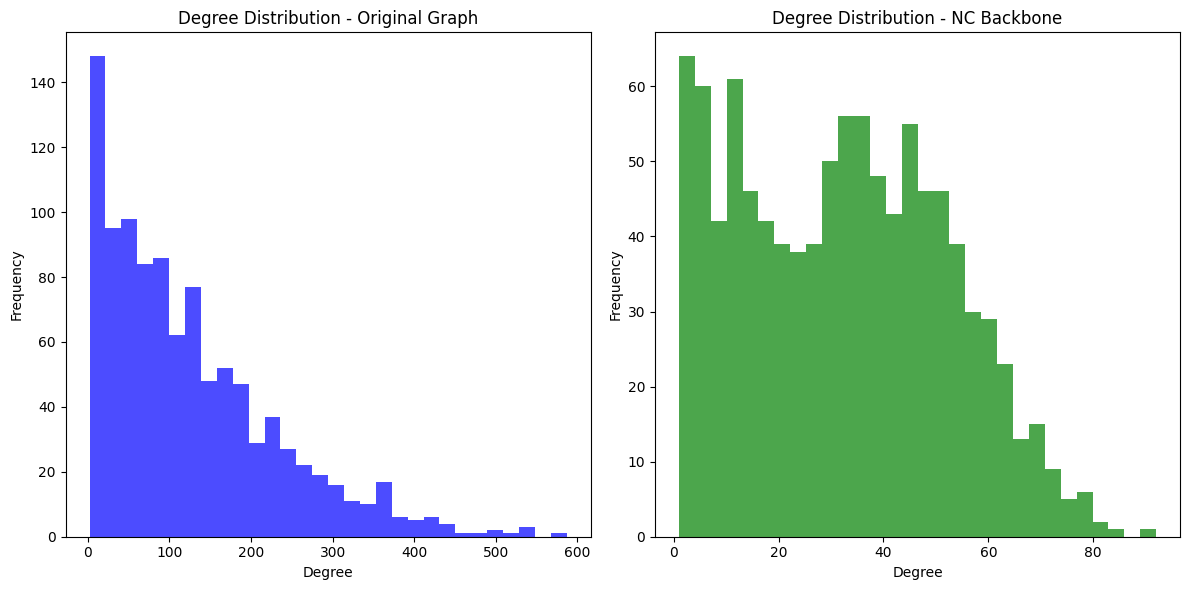

In [36]:
# Degree dis.t of original graph vs NC backbone vs DF backbone in one figure with 3 subplots
def plot_degree_distributions(G_original, G_NC_backbone_3):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original graph
    degrees_original = [d for n, d in G_original.degree()]
    axes[0].hist(degrees_original, bins=30, color='blue', alpha=0.7)
    axes[0].set_title('Degree Distribution - Original Graph')
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('Frequency')

    # NC Backbone
    degrees_nc = [d for n, d in G_NC_backbone_3.degree()]
    axes[1].hist(degrees_nc, bins=30, color='green', alpha=0.7)
    axes[1].set_title('Degree Distribution - NC Backbone')
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_degree_distributions(G_lyrics, NC_backbone)

The edge weight distribution of the original graph and backbone is plotted.

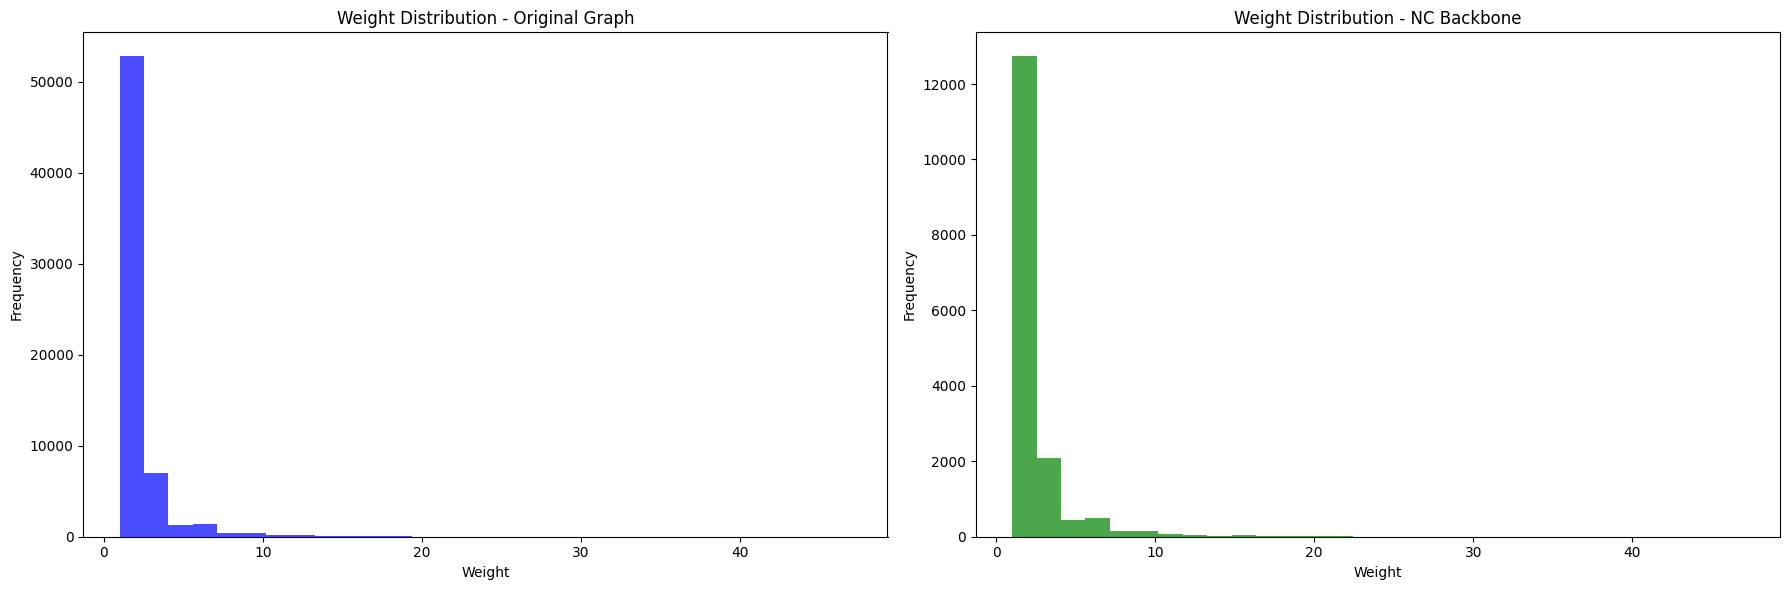

In [41]:
# Weight distribution of original graph vs NC backbone vs DF backbone in one figure with 3 subplots
def plot_weight_distributions(G_original, G_NC_backbone_3, weight_attr="weight"):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Original graph
    weights_original = [data.get(weight_attr, 1.0) for u, v, data in G_original.edges(data=True)]
    axes[0].hist(weights_original, bins=30, color='blue', alpha=0.7)
    axes[0].set_title('Weight Distribution - Original Graph')
    axes[0].set_xlabel('Weight')
    axes[0].set_ylabel('Frequency')

    # NC Backbone
    weights_nc = [data.get('nij', 1.0) for u, v, data in G_NC_backbone_3.edges(data=True)]
    axes[1].hist(weights_nc, bins=30, color='green', alpha=0.7)
    axes[1].set_title('Weight Distribution - NC Backbone')
    axes[1].set_xlabel('Weight')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_weight_distributions(G_lyrics, NC_backbone, weight_attr="weight")



The assortativity of the graph and backbone is calculated.

In [ ]:
# assortativity of original graph vs NC backbone
print(f"Assortativity of Original Graph: {nx.degree_assortativity_coefficient(G_lyrics)}")
print(f"Assortativity of NC Backbone: {nx.degree_assortativity_coefficient(NC_backbone)}")

Assortativity of Original Graph: 0.0016330127467191564
Assortativity of NC Backbone: 0.08630496775567546


The centrality of the original graph and backbone is calculated.

In [42]:
# centrality measures of NC backbone
betweenness = nx.betweenness_centrality(NC_backbone)
closeness = nx.closeness_centrality(NC_backbone)
eigenvector = nx.eigenvector_centrality(NC_backbone)
print(f"Top 10 Betweenness Centrality: {sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]}")
print(f"Top 10 Closeness Centrality: {sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]}")
print(f"Top 10 Eigenvector Centrality: {sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:10]}")

Top 10 Betweenness Centrality: [('Jay_Park', 0.021885763806882754), ('BTS', 0.01977069456965099), ('Hillsong_United', 0.016470656925806623), ('Enrique_Iglesias', 0.01598141612812743), ('Chance_The_Rapper', 0.014035924861155465), ('Lana_Del_Rey', 0.013801904812498489), ('Al_Green', 0.012342903799894356), ('Alicia_Keys', 0.009646295975165047), ('Daft_Punk', 0.00958473587534671), ('Alabama_Shakes', 0.009341780685261758)]
Top 10 Closeness Centrality: [('Yeah_Yeah_Yeahs', 0.45903890160183064), ('Lana_Del_Rey', 0.4577818347786399), ('Sean_Paul', 0.45078651685393256), ('The_Clash', 0.4491715181370354), ('The_xx', 0.44796784278695845), ('Sugar_Ray', 0.44716897012929113), ('Daft_Punk', 0.44657168299198574), ('The_1975', 0.44657168299198574), ('The_Offspring', 0.4459759893285905), ('Boys_Like_Girls', 0.4457777777777778)]
Top 10 Eigenvector Centrality: [('Yeah_Yeah_Yeahs', 0.08402067201063797), ('Pink_Floyd', 0.0773789052674066), ('The_Shins', 0.07727339084700034), ('Elton_John', 0.07716600660418

Skal vi måske bruge denne til at beregne modularitet?:

In [38]:
def modularity(G, partition):
    """
    Compute modularity using Eq. 9.12:
    """
    L = G.number_of_edges()  # total edges
    degrees = dict(G.degree())

    M = 0.0
    for community in partition:
        # Internal edges in community
        L_c = G.subgraph(community).number_of_edges()
        # Sum of degrees in community
        k_c = sum(degrees[node] for node in community)
        M += (L_c / L) - (k_c / (2 * L)) ** 2

    return M